In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import FormatStrFormatter
from matplotlib import rcParams

from scipy.interpolate import splrep, BSpline
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Import custom utility functions
from evaluation_utils import root_mean_squared_percentage_error
import feature_utils, dict_utils, plot_utils, evaluation_utils

import os, warnings, math

# Configure matplotlib settings
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Verdana'

# Suppress warnings
warnings.filterwarnings('ignore')

c:\Users\lawna\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\lawna\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\lawna\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Overview
This script benchmarks various naive and Severson's models for predicting battery cycle life using engineered features derived from battery data. The models include naive linear, naive constant, and two ElasticNet models presented by Severson. Features used are taken from charge/discharge capacities and cycle life (constant)

The goal is to evaluate the predictive performance of different models and capacity-related feature sets taken from the first 10 cycles, assessing their accuracy in battery cycle life prediction. These models are to be compared to our proposed Temperature models.

## Load and extract features

In [2]:
# Load the preprocessed battery dictionary
battDict = np.load(os.path.join('.', 'batteryDictionary.npy'), allow_pickle=True).item()

In [3]:
# Generate feature dictionaries for T(V), dT/dV, and Severson features
T_V = feature_utils.create_T_V(battDict=battDict, cycleList=[str(x) for x in range(2, 101)], avgUpToCycle=100)
dTdV = feature_utils.create_dTdV(battDict=battDict, cycleList=[str(x) for x in range(2, 101)], avgUpToCycle=100)
Severson = feature_utils.create_Severson(battDict=battDict, cycleList=['2', '10'])

# Extract unique feature keys for each feature dictionary
TVKeynameUnique = dict_utils.get_unique_keyname_tuple(T_V)
dTdVKeynameUnique = dict_utils.get_unique_keyname_tuple(dTdV)
SeversonKeynameUnique = list(Severson.keys())

In [4]:
# Split data into training (3C batteries) and testing (2C batteries) sets
train_index = [i for i, cellNo in enumerate(battDict.keys()) if cellNo[0] == '3']
test_index = [i for i, cellNo in enumerate(battDict.keys()) if cellNo[0] == '2']
markerArr = np.append(['v'] * len(train_index), ['s'] * len(test_index))

In [5]:
# Extract target variable (cycle life) for training and testing
y_train = T_V['cycleLife'][train_index].reshape(-1, 1)
y_test = T_V['cycleLife'][test_index].reshape(-1, 1)
y_all = np.concatenate((y_train, y_test))

## Create dataframe

In [6]:
# Initialize a DataFrame to store feature importance and model performance
feat_df = pd.DataFrame(columns=['dictionary', 'featName', 'valueArray', 'rScore'])

# Helper function to evaluate features and append results to the DataFrame
def evaluate_features(featureDict, featureKeynameList, dictionaryName, y):
    X = np.empty((len(y), 0))
    for feat in featureKeynameList:
        X = np.append(X, featureDict[feat].reshape(-1, 1), axis=1)
    rScore = evaluation_utils.rScore(X, y, featureKeynameList, toPrint=False)
    for i, feat in enumerate(featureKeynameList):
        feat_df.loc[len(feat_df)] = {'dictionary': dictionaryName, 'featName': feat, 'valueArray': X[:, i], 'rScore': rScore[i]}

# Evaluate T(V) features
evaluate_features(T_V, [(mode, stat, 'Average_2to10') for mode in ['Charge', 'Discharge'] for stat in TVKeynameUnique[1][:-1]], 'T_V', y_all)

# Evaluate dT/dV features
evaluate_features(dTdV, [(mode, stat, 'Average_2to10') for mode in ['Charge', 'Discharge'] for stat in dTdVKeynameUnique[1][:-1]], 'dTdV', y_all)

# Evaluate Severson features
evaluate_features(Severson, SeversonKeynameUnique[:-1], 'Severson', y_all)

### Benchmark 1: Univariate linear regression using Qd cycle 2

Benchmark: Linear regression using Qd at cycle 2 

MAE_all: 49.1 
MAE_train: 30.4 
MAE_test: 84.2 

MAPE_all: 16.7 % 
MAPE_train: 14.5 % 
MAPE_test: 21.0 % 

RMSE_all: 62.3 
RMSE_train: 38.1 
RMSE_test: 91.7 

RMSPE_all: 20.9 % 
RMSPE_train: 19.8 % 
RMSPE_test: 22.9 %

r2-scores
All data r2-score: 0.526
Train data r2-score: 0.667
Test data r2-score: -103.244

Normal-scale scores
All data score: 0.526
Train data score: 0.667
Test data score: -103.244


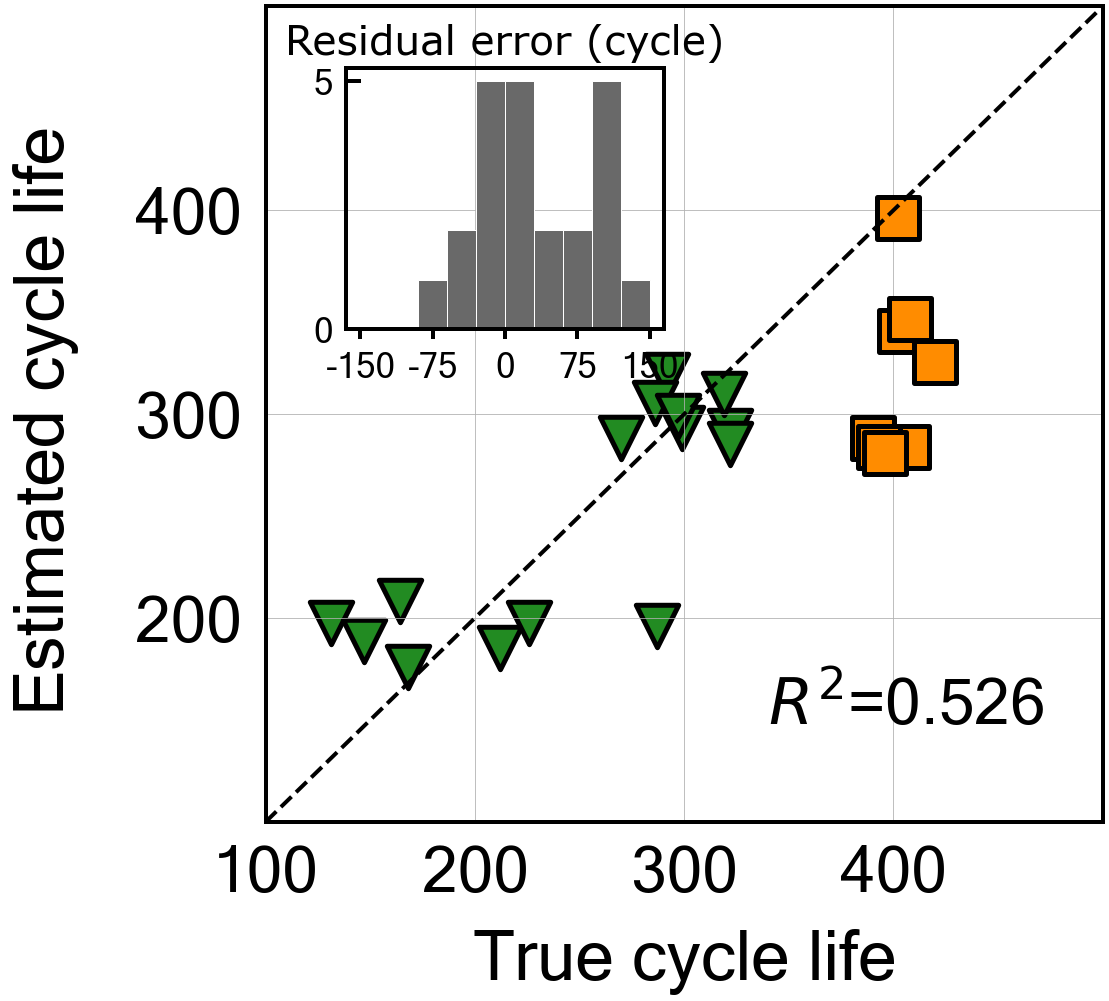

In [7]:
featQd2_all = Severson['Qd_c2'].reshape(-1, 1)
scaler = StandardScaler().fit(featQd2_all[train_index])
featQd2_train_scaled = scaler.transform(featQd2_all[train_index])
featQd2_test_scaled = scaler.transform(featQd2_all[test_index])
featQd2_all_scaled = np.concatenate((featQd2_train_scaled, featQd2_test_scaled))

# Train linear regression model
regLN = LinearRegression().fit(featQd2_train_scaled, y_train)
benchQd2All = regLN.predict(featQd2_all_scaled)
benchQd2Train = regLN.predict(featQd2_train_scaled)
benchQd2Test = regLN.predict(featQd2_test_scaled)

print("Benchmark: Linear regression using Qd at cycle 2",
    "\n\nMAE_all: %.1f" % (mean_absolute_error(y_true = y_all, y_pred = benchQd2All)),
    "\nMAE_train: %.1f" % (mean_absolute_error(y_true = y_train, y_pred = benchQd2Train)),
    "\nMAE_test: %.1f" % (mean_absolute_error(y_true = y_test, y_pred = benchQd2Test)),
    
    "\n\nMAPE_all: %.1f %%" % (mean_absolute_percentage_error(y_true = y_all, y_pred = benchQd2All)* 100),
    "\nMAPE_train: %.1f %%" % (mean_absolute_percentage_error(y_true = y_train, y_pred = benchQd2Train)* 100),
    "\nMAPE_test: %.1f %%" % (mean_absolute_percentage_error(y_true = y_test, y_pred = benchQd2Test)* 100),
    
    "\n\nRMSE_all: %.1f" % (math.sqrt(mean_squared_error(y_true = y_all, y_pred = benchQd2All))),
    "\nRMSE_train: %.1f" % (math.sqrt(mean_squared_error(y_true = y_train, y_pred = benchQd2Train))),
    "\nRMSE_test: %.1f" % (math.sqrt(mean_squared_error(y_true = y_test, y_pred = benchQd2Test))),
    
    "\n\nRMSPE_all: %.1f %%" % (root_mean_squared_percentage_error(y_true = y_all, y_pred = benchQd2All) * 100),
    "\nRMSPE_train: %.1f %%" % (root_mean_squared_percentage_error(y_true = y_train, y_pred = benchQd2Train)* 100),
    "\nRMSPE_test: %.1f %%" % (root_mean_squared_percentage_error(y_true = y_test, y_pred = benchQd2Test)* 100)
    )
print("\nr2-scores")
print("All data r2-score: %.3f" % (r2_score(y_true = y_all, y_pred = benchQd2All)))
print("Train data r2-score: %.3f" % (r2_score(y_true = y_train, y_pred = benchQd2Train)))
print("Test data r2-score: %.3f" % (r2_score(y_true = y_test, y_pred = benchQd2Test)))

# And plot the results
X_all_scaled_best = featQd2_all_scaled
y_all_scaled = y_all
modelBest = regLN
modelName = 'Qd cycle 2'
stringOutput = plot_utils.build_all_comparison_graph(X_all_scaled_best, y_all_scaled, modelBest, len_list = [len(train_index), len(test_index)], 
                                                     markerArr = markerArr, name=modelName, markerSize=1800)#, save = saveFilePath)

### Benchmark 2: Average cycle life - train set (constant value)

In [8]:
benchMean = np.mean(y_train)
benchMeanAll = np.full(np.shape(y_all), benchMean)
benchMeanTrain = np.full(np.shape(y_train), benchMean)
benchMeanTest = np.full(np.shape(y_test), benchMean)

print("Benchmark: Overall data average cycle life (i.e. constant %.0f)"%(benchMean),
    "\n\nMAE_all: %.1f" % (mean_absolute_error(y_true = y_all, y_pred = benchMeanAll)),
    "\nMAE_train: %.1f" % (mean_absolute_error(y_true = y_train, y_pred = benchMeanTrain)),
    "\nMAE_test: %.1f" % (mean_absolute_error(y_true = y_test, y_pred = benchMeanTest)),
    
    "\n\nMAPE_all: %.1f %%" % (mean_absolute_percentage_error(y_true = y_all, y_pred = benchMeanAll)* 100),
    "\nMAPE_train: %.1f %%" % (mean_absolute_percentage_error(y_true = y_train, y_pred = benchMeanTrain)* 100),
    "\nMAPE_test: %.1f %%" % (mean_absolute_percentage_error(y_true = y_test, y_pred = benchMeanTest)* 100),
    
    "\n\nRMSE_all: %.1f" % (math.sqrt(mean_squared_error(y_true = y_all, y_pred = benchMeanAll))),
    "\nRMSE_train: %.1f" % (math.sqrt(mean_squared_error(y_true = y_train, y_pred = benchMeanTrain))),
    "\nRMSE_test: %.1f" % (math.sqrt(mean_squared_error(y_true = y_test, y_pred = benchMeanTest))),
    
    "\n\nRMSPE_all: %.1f %%" % (root_mean_squared_percentage_error(y_true = y_all, y_pred = benchMeanAll) * 100),
    "\nRMSPE_train: %.1f %%" % (root_mean_squared_percentage_error(y_true = y_train, y_pred = benchMeanTrain)* 100),
    "\nRMSPE_test: %.1f %%" % (root_mean_squared_percentage_error(y_true = y_test, y_pred = benchMeanTest)* 100),
    )
print("\nr2-scores")
print("All data r2-score: %.3f" % (r2_score(y_true = y_all, y_pred = benchMeanAll)))
print("Train data r2-score: %.3f" % (r2_score(y_true = y_train, y_pred = benchMeanTrain)))
print("Test data r2-score: %.3f" % (r2_score(y_true = y_test, y_pred = benchMeanTest)))

Benchmark: Overall data average cycle life (i.e. constant 249) 

MAE_all: 92.2 
MAE_train: 59.8 
MAE_test: 152.9 

MAPE_all: 32.2 % 
MAPE_train: 29.1 % 
MAPE_test: 38.0 % 

RMSE_all: 104.9 
RMSE_train: 66.1 
RMSE_test: 153.2 

RMSPE_all: 37.7 % 
RMSPE_train: 37.5 % 
RMSPE_test: 38.0 %

r2-scores
All data r2-score: -0.346
Train data r2-score: 0.000
Test data r2-score: -289.604


### Benchmark 3: Variance model from Severson

In [9]:
# Function for plotting the trained benchmark models 3 and 4
def train_ElasticNet_benchmark(X, model, y_true, indexList = list(), cellName='All cells', modelName='All features', markerArr = 'o', 
                     lifeLimit=[0, 750], predTickStep = 250, textSize=64, markerSize=1800, fontName = 'Microsoft Sans Serif', 
                     spinesColor = 'black', titleName = '',
                     MinMax = False, save=False):
    print("Training ElasticNet model, tuned with ElasticNetCV")
    predTickArr = np.arange(lifeLimit[0], lifeLimit[1]+1, predTickStep)

    X_all_scaled = X
    X_train_scaled = X_all_scaled[indexList[0]]
    X_test_scaled = X_all_scaled[indexList[1]]
    
    y_train = y_true[indexList[0]]
    y_test = y_true[indexList[1]]
    y_all = np.concatenate((y_train, y_test))

    y_pred_train = model.predict(X_train_scaled).reshape(-1, 1)
    y_pred_test = model.predict(X_test_scaled).reshape(-1, 1)
    y_pred_all = np.concatenate((y_pred_train, y_pred_test))

    print("Model parameters\nAlpha: %.4f, L1_ratio: %.2f, all score: %.3f, train score: %.3f, test score: %.3f" %(model.alpha_, model.l1_ratio_, model.score(X_all_scaled, y_all), model.score(X_train_scaled, y_train), model.score(X_test_scaled, y_test)))
    
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_title(titleName, fontsize=textSize-6, pad=20)
    ax.plot(lifeLimit, lifeLimit, color=spinesColor, linestyle='--', linewidth=4, zorder=2)
    ax.set_ylabel("Estimated cycle life", fontsize=textSize+5, fontname=fontName)
    ax.set_xlabel("True cycle life", fontsize=textSize+5, fontname=fontName)
    ax.set_xticks(predTickArr[:-1])
    ax.set_xticklabels(predTickArr[:-1], fontname=fontName, y = -0.02)
    ax.set_yticks(predTickArr[1:-1])
    ax.set_yticklabels(predTickArr[1:-1], fontname=fontName, x = -0.02)
    ax.set_ylim(lifeLimit)
    ax.set_xlim(lifeLimit)
    
    ax.tick_params(labelsize=textSize, left=False, bottom=False)
    ax.yaxis.set_label_coords(-0.23, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.13)
    
    for axis in ['top', 'bottom', 'left', 'right']: 
        ax.spines[axis].set_linewidth(4)
        ax.spines[axis].set_color(spinesColor)

    # Turn y values to normal cycle life
    if MinMax != False: rescale = lambda x: MinMax.inverse_transform(x.reshape(-1, 1)).flatten()
    elif np.mean(y_all) < 10: rescale = lambda x: 10**x
    else: rescale = lambda x: x

    y_train = rescale(y_train)
    y_test = rescale(y_test)
    y_all = rescale(y_all)
    y_pred_train = rescale(y_pred_train).reshape(-1, 1)
    y_pred_test = rescale(y_pred_test).reshape(-1, 1)
    y_pred_all = rescale(y_pred_all).reshape(-1, 1)

    ax.text(x=0.6, y=0.12, s="$R^{}$={:.3f}".format('2', r2_score(y_all, y_pred_all)), 
            fontsize=textSize, zorder=3, fontname=fontName,transform=ax.transAxes)

    # Train
    for i, indexCell in enumerate(indexList[0]):
        ax.scatter(y_train[i], y_pred_train[i], color='forestgreen', label='Train', s=markerSize, zorder=1,
                marker=markerArr[indexCell], edgecolors='k', linewidths=5)
    
    # Test
    for i, indexCell in enumerate(indexList[1]):
        ax.scatter(y_test[i], y_pred_test[i], color='darkorange', label='Test', s=markerSize, zorder=2, 
                marker=markerArr[indexCell], edgecolors='k', linewidths=5)


    print("Metrics according to plot scale (non-log10)")
    print("All: MAE: %.1f, MAPE: %.2f %%, RMSE: %.1f, RMSPE: %.2f %%, r2-score: %.3f" % (mean_absolute_error(y_true = y_all, y_pred = y_pred_all), mean_absolute_percentage_error(y_true = y_all, y_pred = y_pred_all) * 100, 
                                                                                         mean_squared_error(y_true = y_all, y_pred = y_pred_all, squared=False), root_mean_squared_percentage_error(y_true = y_all, y_pred = y_pred_all) * 100, r2_score(y_true = y_all, y_pred = y_pred_all)))
    print("Train: MAE: %.1f, MAPE: %.2f %%, RMSE: %.1f, RMSPE: %.2f %%, r2-score: %.3f" % (mean_absolute_error(y_true = y_train, y_pred = y_pred_train), mean_absolute_percentage_error(y_true = y_train, y_pred = y_pred_train) * 100, 
                                                                                           mean_squared_error(y_true = y_train, y_pred = y_pred_train, squared=False), root_mean_squared_percentage_error(y_true = y_train, y_pred = y_pred_train) * 100, r2_score(y_true = y_train, y_pred = y_pred_train)))
    print("Test: MAE: %.1f, MAPE: %.2f %%, RMSE: %.1f, RMSPE: %.2f %%, r2-score: %.3f" % (mean_absolute_error(y_true = y_test, y_pred = y_pred_test), mean_absolute_percentage_error(y_true = y_test, y_pred = y_pred_test) * 100, 
                                                                                          mean_squared_error(y_true = y_test, y_pred = y_pred_test, squared=False), root_mean_squared_percentage_error(y_true = y_test, y_pred = y_pred_test) * 100, r2_score(y_true = y_test, y_pred = y_pred_test)))
    
    if (save != False):
        fig.savefig(save, dpi=1000, bbox_inches='tight')
        
    plt.show()
    return model

Benchmark: ElasticNet Regression on Variance Model 

MAE_all: 74.4 
MAE_train: 58.4 
MAE_test: 104.5 

MAPE_all: 27.5 % 
MAPE_train: 28.2 % 
MAPE_test: 26.2 % 

RMSE_all: 86.8 
RMSE_train: 63.9 
RMSE_test: 118.3 

RMSPE_all: 33.7 % 
RMSPE_train: 35.7 % 
RMSPE_test: 29.7 %

r2-scores
All data r2-score: 0.079
Train data r2-score: 0.063
Test data r2-score: -172.310



Training ElasticNet model, tuned with ElasticNetCV
Model parameters
Alpha: 0.4687, L1_ratio: 0.04, all score: 0.079, train score: 0.063, test score: -172.310
Metrics according to plot scale (non-log10)
All: MAE: 74.4, MAPE: 27.52 %, RMSE: 86.8, RMSPE: 33.72 %, r2-score: 0.079
Train: MAE: 58.4, MAPE: 28.24 %, RMSE: 63.9, RMSPE: 35.68 %, r2-score: 0.063
Test: MAE: 104.5, MAPE: 26.19 %, RMSE: 118.3, RMSPE: 29.71 %, r2-score: -172.310


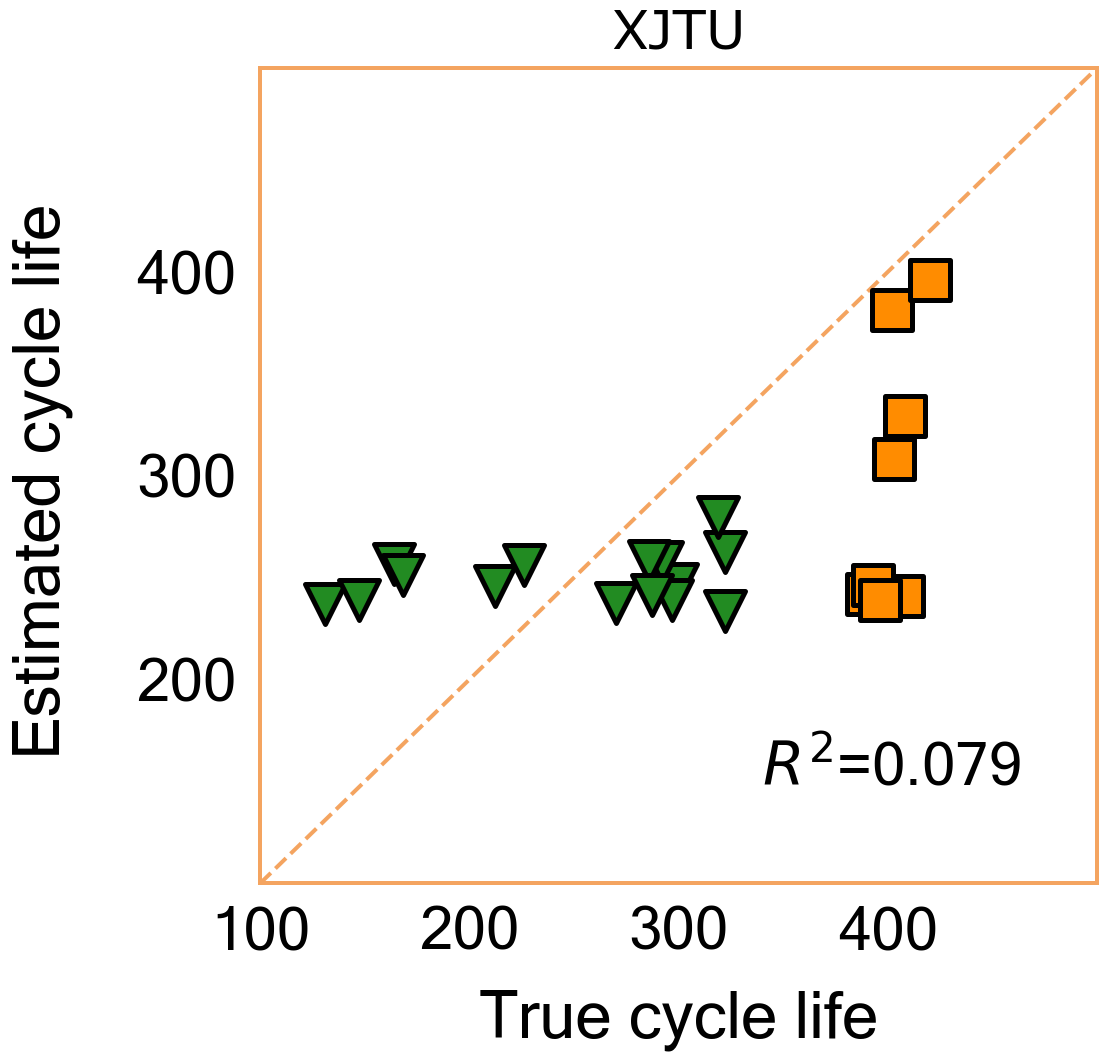

In [10]:
featVar_all = Severson['Q_V_Variance'].reshape(-1, 1)
scaler = StandardScaler().fit(featVar_all[train_index])
featVar_train_scaled = scaler.transform(featVar_all[train_index])
featVar_test_scaled = scaler.transform(featVar_all[test_index])
featVar_all_scaled = np.concatenate((featVar_train_scaled, featVar_test_scaled))

# Train ElasticNet model
regEN = ElasticNetCV(l1_ratio=np.linspace(0.01,1,100), cv=4, random_state=25, max_iter=100000, n_jobs=3, tol=1e-2, verbose=0, selection='random').fit(featVar_train_scaled, y_train)
model = regEN

# Predict on all, train, and test sets
benchVarAll = model.predict(featVar_all_scaled).reshape(-1, 1)
benchVarTrain = model.predict(featVar_train_scaled).reshape(-1, 1)
benchVarTest = model.predict(featVar_test_scaled).reshape(-1, 1)

print("Benchmark: ElasticNet Regression on Variance Model",
    "\n\nMAE_all: %.1f" % (mean_absolute_error(y_true = y_all, y_pred = benchVarAll)),
    "\nMAE_train: %.1f" % (mean_absolute_error(y_true = y_train, y_pred = benchVarTrain)),
    "\nMAE_test: %.1f" % (mean_absolute_error(y_true = y_test, y_pred = benchVarTest)),
    
    "\n\nMAPE_all: %.1f %%" % (mean_absolute_percentage_error(y_true = y_all, y_pred = benchVarAll)* 100),
    "\nMAPE_train: %.1f %%" % (mean_absolute_percentage_error(y_true = y_train, y_pred = benchVarTrain)* 100),
    "\nMAPE_test: %.1f %%" % (mean_absolute_percentage_error(y_true = y_test, y_pred = benchVarTest)* 100),
    
    "\n\nRMSE_all: %.1f" % (math.sqrt(mean_squared_error(y_true = y_all, y_pred = benchVarAll))),
    "\nRMSE_train: %.1f" % (math.sqrt(mean_squared_error(y_true = y_train, y_pred = benchVarTrain))),
    "\nRMSE_test: %.1f" % (math.sqrt(mean_squared_error(y_true = y_test, y_pred = benchVarTest))),
    
    "\n\nRMSPE_all: %.1f %%" % (root_mean_squared_percentage_error(y_true = y_all, y_pred = benchVarAll) * 100),
    "\nRMSPE_train: %.1f %%" % (root_mean_squared_percentage_error(y_true = y_train, y_pred = benchVarTrain)* 100),
    "\nRMSPE_test: %.1f %%" % (root_mean_squared_percentage_error(y_true = y_test, y_pred = benchVarTest)* 100),
    )
print("\nr2-scores")
print("All data r2-score: %.3f" % (r2_score(y_true = y_all, y_pred = benchVarAll)))
print("Train data r2-score: %.3f" % (r2_score(y_true = y_train, y_pred = benchVarTrain)))
print("Test data r2-score: %.3f" % (r2_score(y_true = y_test, y_pred = benchVarTest)))

# Set variable for plotting
X_all_scaled_best = featVar_all_scaled
y_all_scaled = y_all
modelBest = model
modelName = 'Variance'

# Uncomment the following line to save the plot
# saveDir = os.path.join('.', modelName+".png")
spinesColor = "sandybrown"
print("\n\n")

_ = train_ElasticNet_benchmark(X = featVar_all_scaled, y_true = y_all, model = model,
                                    lifeLimit = [100, 500], predTickStep = 100, textSize = 60, markerSize = 1600, fontName = 'Microsoft Sans Serif',
                                    indexList = [np.arange(0, len(train_index)), np.arange(len(train_index), len(train_index) + len(test_index))], 
                                    cellName = "Temperature", modelName = modelName, titleName = "XJTU", spinesColor = spinesColor, markerArr = markerArr)#, save = saveDir)

### Benchmark 4: Discharge model from Severson

Benchmark: ElasticNet Regression on Discharge Model 

MAE_all: 47.6 
MAE_train: 25.1 
MAE_test: 89.8 

MAPE_all: 15.5 % 
MAPE_train: 12.0 % 
MAPE_test: 22.2 % 

RMSE_all: 66.5 
RMSE_train: 32.7 
RMSE_test: 103.4 

RMSPE_all: 19.9 % 
RMSPE_train: 16.3 % 
RMSPE_test: 25.2 %

r2-scores
All data r2-score: 0.460
Train data r2-score: 0.755
Test data r2-score: -131.499



Training ElasticNet model, tuned with ElasticNetCV
Model parameters
Alpha: 4.6097, L1_ratio: 0.99, all score: 0.460, train score: 0.755, test score: -131.499
Metrics according to plot scale (non-log10)
All: MAE: 47.6, MAPE: 15.53 %, RMSE: 66.5, RMSPE: 19.86 %, r2-score: 0.460
Train: MAE: 25.1, MAPE: 12.00 %, RMSE: 32.7, RMSPE: 16.32 %, r2-score: 0.755
Test: MAE: 89.8, MAPE: 22.15 %, RMSE: 103.4, RMSPE: 25.19 %, r2-score: -131.499


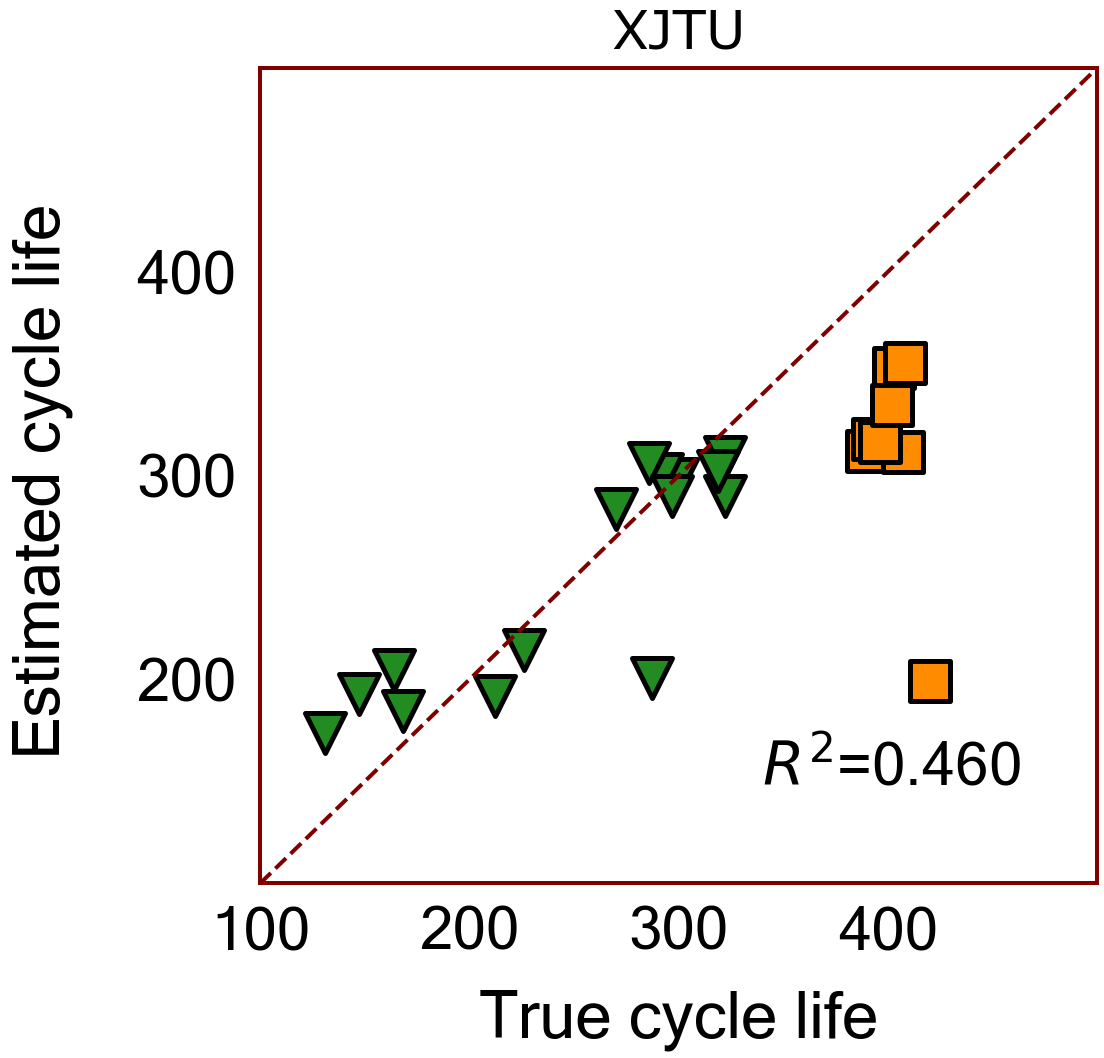

In [11]:
# Keynames for the features used in discharge model
keyNameDisList = ['Q_V_Variance', 'Q_V_Skewness', 'Q_V_Kurtosis', 'Q_V_Minimum', 'Qd_c2', 'Qd_max-c2']
featDis_all = np.empty(shape=(len(y_all), 0))

for keyName in keyNameDisList:
    featDis_all = np.append(featDis_all, Severson[keyName].reshape(-1, 1), axis=1)

scaler = StandardScaler().fit(featDis_all[train_index])
featDis_train_scaled = scaler.transform(featDis_all[train_index])
featDis_test_scaled = scaler.transform(featDis_all[test_index])
featDis_all_scaled = np.concatenate((featDis_train_scaled, featDis_test_scaled))

# Train Discharge model using ElasticNet
regEN = ElasticNetCV(l1_ratio=np.linspace(0.01,1,100), cv=4, random_state=25, max_iter=100000, n_jobs=3, tol=1e-2, verbose=0, selection='random').fit(featDis_train_scaled, y_train)
model = regEN

benchDisAll = model.predict(featDis_all_scaled).reshape(-1, 1)
benchDisTrain = model.predict(featDis_train_scaled).reshape(-1, 1)
benchDisTest = model.predict(featDis_test_scaled).reshape(-1, 1)

print("Benchmark: ElasticNet Regression on Discharge Model",
    "\n\nMAE_all: %.1f" % (mean_absolute_error(y_true = y_all, y_pred = benchDisAll)),
    "\nMAE_train: %.1f" % (mean_absolute_error(y_true = y_train, y_pred = benchDisTrain)),
    "\nMAE_test: %.1f" % (mean_absolute_error(y_true = y_test, y_pred = benchDisTest)),
    
    "\n\nMAPE_all: %.1f %%" % (mean_absolute_percentage_error(y_true = y_all, y_pred = benchDisAll)* 100),
    "\nMAPE_train: %.1f %%" % (mean_absolute_percentage_error(y_true = y_train, y_pred = benchDisTrain)* 100),
    "\nMAPE_test: %.1f %%" % (mean_absolute_percentage_error(y_true = y_test, y_pred = benchDisTest)* 100),
    
    "\n\nRMSE_all: %.1f" % (math.sqrt(mean_squared_error(y_true = y_all, y_pred = benchDisAll))),
    "\nRMSE_train: %.1f" % (math.sqrt(mean_squared_error(y_true = y_train, y_pred = benchDisTrain))),
    "\nRMSE_test: %.1f" % (math.sqrt(mean_squared_error(y_true = y_test, y_pred = benchDisTest))),
    
    "\n\nRMSPE_all: %.1f %%" % (root_mean_squared_percentage_error(y_true = y_all, y_pred = benchDisAll) * 100),
    "\nRMSPE_train: %.1f %%" % (root_mean_squared_percentage_error(y_true = y_train, y_pred = benchDisTrain)* 100),
    "\nRMSPE_test: %.1f %%" % (root_mean_squared_percentage_error(y_true = y_test, y_pred = benchDisTest)* 100)
    )
print("\nr2-scores")
print("All data r2-score: %.3f" % (r2_score(y_true = y_all, y_pred = benchDisAll)))
print("Train data r2-score: %.3f" % (r2_score(y_true = y_train, y_pred = benchDisTrain)))
print("Test data r2-score: %.3f" % (r2_score(y_true = y_test, y_pred = benchDisTest)))

# Set variable for plotting
X_all_scaled_best = featDis_all_scaled
y_all_scaled = y_all
modelBest = model
modelName = 'Discharge'

# Uncomment the following line to save the plot
# saveDir = os.path.join('.', modelName+".png")
spinesColor = "maroon"
print("\n\n")
_ = train_ElasticNet_benchmark(X = X_all_scaled_best, y_true = y_all, model = model,
                                    lifeLimit = [100, 500], predTickStep = 100, textSize = 60, markerSize = 1600, fontName = 'Microsoft Sans Serif',
                                    indexList = [np.arange(0, len(train_index)), np.arange(len(train_index), len(train_index) + len(test_index))], 
                                    cellName = "All cells", modelName = modelName, titleName = "XJTU", spinesColor = spinesColor, markerArr = markerArr)#, save = saveDir)